# Pareto Frontier Analysis

## Overview
Multi-objective optimization for insurance decisions using Pareto frontiers.  We explore trade-offs between ROE, bankruptcy risk, and premium cost, identify knee-point solutions, and compare frontier generation methods.

- **Prerequisites**: [optimization/01_optimization_overview](01_optimization_overview.ipynb)
- **Estimated runtime**: 1-2 minutes
- **Audience**: [Practitioner] / [Developer]

In [1]:
"""Google Colab setup: mount Drive and install package dependencies.

Run this cell first. If prompted to restart the runtime, do so, then re-run all cells.
This cell is a no-op when running locally.
"""
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

    NOTEBOOK_DIR = '/content/drive/My Drive/Colab Notebooks/ei_notebooks/optimization'

    os.chdir(NOTEBOOK_DIR)
    if NOTEBOOK_DIR not in sys.path:
        sys.path.append(NOTEBOOK_DIR)

    !pip install ergodic-insurance -q 2>&1 | tail -3
    print('\nSetup complete. If you see numpy/scipy import errors below,')
    print('restart the runtime (Runtime > Restart runtime) and re-run all cells.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Setup complete. If you see numpy/scipy import errors below,
restart the runtime (Runtime > Restart runtime) and re-run all cells.


## Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import multiprocessing

warnings.filterwarnings("ignore")

from ergodic_insurance.pareto_frontier import (
    Objective, ObjectiveType, ParetoFrontier, ParetoPoint,
)
from ergodic_insurance.config import ManufacturerConfig
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.insurance_program import (
    EnhancedInsuranceLayer, InsuranceProgram,
)
from ergodic_insurance.loss_distributions import ManufacturingLossGenerator

plt.style.use("seaborn-v0_8-darkgrid")
SEED = 42
np.random.seed(SEED)
N_CORES = multiprocessing.cpu_count()
print(f"Number of CPU cores: {N_CORES}")  # Available parallel cores for sensitivity sweep
CI = False      # Set True to skip heavy computations

Number of CPU cores: 44


## Part I: Parameter Setup

### Configure Our Manufacturing Company

We model a volatile manufacturing company with the following characteristics:

| Parameter | Value | Why it matters |
|---|---|---|
| Total assets | \$5M | Sets the scale of risk (a single large loss can be existential) |
| Asset turnover | 2.0x | Revenue = Assets * turnover = ~\$10M |
| Operating margin | 15% | \$3M Operating income (the "cushion" for absorbing losses) |
| Revenue volatility | 15% | Operational asset uncertainty |
| Tax rate | 25% | Tax shield reduces net cost of both premiums and retained losses |
| Earnings retention | 70% | 70% of after-tax profit reinvested for growth |

In [3]:
# --- Economic Parameters
ATR = 2.0                # Asset turnover ratio
OPERATING_MARGIN = 0.15  # 12% EBIT margin before Insurable Losses
REV_VOL = 0.50           # Revenue volatility (annualized)
INITIAL_ASSETS = 5_000_000

# --- Company Configuration ---
mfg_config = ManufacturerConfig(
    initial_assets=INITIAL_ASSETS,          # $15M total assets
    asset_turnover_ratio=ATR,               # Revenue = Assets Ãƒâ€” turnover = $22.5M
    base_operating_margin=OPERATING_MARGIN, # 12% EBIT margin -> $2.7M/yr operating income
    tax_rate=0.25,                          # 25% corporate tax
    retention_ratio=0.70,                   # 70% earnings retained for growth
)

# Display company profile
revenue = mfg_config.initial_assets * mfg_config.asset_turnover_ratio
ebit = revenue * mfg_config.base_operating_margin
print("=" * 60)
print("MANUFACTURING COMPANY PROFILE")
print("=" * 60)
print(f"Total Assets:          ${mfg_config.initial_assets:>14,.0f}")
print(f"Annual Revenue:        ${revenue:>14,.0f}")
print(f"Operating Income:      ${ebit:>14,.0f}")
print(f"Operating Margin:      {mfg_config.base_operating_margin:>14.1%}")
print(f"Asset Turnover:        {mfg_config.asset_turnover_ratio:>14.1f}x")
print(f"Revenue Volatility:    {REV_VOL:>14}")
print(f"Tax Rate:              {mfg_config.tax_rate:>13.1%}")
print(f"Retention Ratio:       {mfg_config.retention_ratio:>13.1%}")
print("=" * 60)

MANUFACTURING COMPANY PROFILE
Total Assets:          $     5,000,000
Annual Revenue:        $    10,000,000
Operating Income:      $     1,500,000
Operating Margin:               15.0%
Asset Turnover:                   2.0x
Revenue Volatility:               0.5
Tax Rate:                      25.0%
Retention Ratio:               70.0%


<a id="part3"></a>
### The 4-Layer Insurance Program

A realistic commercial insurance program is built in **layers** that stack on top of each other:

```
                                          $100M  +-------------------+
                                                 |  Layer 4: CAT     |
                                                 |  $50M xs $50M     |
                                                 |  Rate: 0.2%       |
                                          $50M   +-------------------+
                                                 |  Layer 3: 2nd Xs  |
                                                 |  $25M xs $25M     |
                                                 |  Rate: 0.4%       |
                                          $25M   +-------------------+
                                                 |  Layer 2: 1st Xs  |
                                                 |  $20M xs $5M      |
                                                 |  Rate: 0.8%       |
                                          $5M    +-------------------+
                                                 |  Layer 1: Primary |
                                                 |  $4.75M xs $250K  |
                                                 |  Rate: 1.5%       |
                                          $250K  +-------------------+
                                                 | Deductible        |
                                          $0     |                   |
                                                 +-------------------+
```

How losses flow through the tower:

- **Losses below \$250K**: Company pays in full (deductible)
- **Losses \$250K - \$5M**: Layer 1 (Primary) responds -- this is the "working layer" with frequent claims
- **Losses \$5M - \$25M**: Layer 2 (1st Excess) picks up the excess
- **Losses \$25M - \$50M**: Layer 3 (2nd Excess) -- infrequent severe losses
- **Losses \$50M - \$100M**: Layer 4 (Catastrophic) -- rare but devastating events
- **Losses above \$100M**: Uninsured -- company bears full exposure

The premium rate (rate-on-line) decreases as you go higher because the probability of reaching that layer drops dramatically.

In [4]:
def create_insurance_program(retention_factor=1.0, limit_factor=1.0):
    """Create a 4-layer manufacturing insurance program.

    Rate-on-line will be tuned later in the simulation.

    Args:
        retention_factor: Multiplier on all attachment points (for optimization).
        limit_factor: Multiplier on all limits (for optimization).
    """
    layers = [
        # Layer 1: Primary (working layer)
        EnhancedInsuranceLayer(
            attachment_point=250_000 * retention_factor,
            limit=(5_000_000 - 250_000) * limit_factor,
            base_premium_rate=0.38,   # 38% rate-on-line (working layer)
            reinstatements=0,
        ),
        # Layer 2: First Excess
        EnhancedInsuranceLayer(
            attachment_point=5_000_000 * retention_factor,
            limit=20_000_000 * limit_factor,
            base_premium_rate=0.015,  # 1.5% rate-on-line
            reinstatements=1,
        ),
        # Layer 3: Second Excess
        EnhancedInsuranceLayer(
            attachment_point=25_000_000 * retention_factor,
            limit=25_000_000 * limit_factor,
            base_premium_rate=0.005,  # 0.5% rate-on-line
            reinstatements=2,
        ),
        # Layer 4: Catastrophic
        EnhancedInsuranceLayer(
            attachment_point=50_000_000 * retention_factor,
            limit=50_000_000 * limit_factor,
            base_premium_rate=0.002,  # 0.2% rate-on-line
            reinstatements=999,        # Effectively unlimited
        ),
    ]
    return InsuranceProgram(
        layers=layers,
        deductible=250_000 * retention_factor,
        name="Manufacturing 4-Layer Program",
    )


# Create baseline program
program = create_insurance_program()
summary = program.get_program_summary()

print("4-LAYER INSURANCE PROGRAM")
print("=" * 70)
print(f"{'Layer':<12} {'Attachment':>12} {'Limit':>12} {'Exhaust Pt':>12} {'Premium':>10}")
print("-" * 70)
for i, layer_info in enumerate(summary['layers']):
    print(f"Layer {i+1:<5}  ${layer_info['attachment']:>11,.0f} ${layer_info['limit']:>11,.0f} "
          f"${layer_info['exhaustion_point']:>11,.0f} ${layer_info['base_premium']:>9,.0f}")
print("-" * 70)
print(f"{'TOTAL':<12} {'':>12} {'':>12} {'':>12} ${summary['annual_base_premium']:>9,.0f}")
print(f"\nDeductible: ${summary['deductible']:,.0f}")
print(f"Total Coverage: ${summary['total_coverage']:,.0f}")

4-LAYER INSURANCE PROGRAM
Layer          Attachment        Limit   Exhaust Pt    Premium
----------------------------------------------------------------------
Layer 1      $    250,000 $  4,750,000 $  5,000,000 $1,805,000
Layer 2      $  5,000,000 $ 20,000,000 $ 25,000,000 $  300,000
Layer 3      $ 25,000,000 $ 25,000,000 $ 50,000,000 $  125,000
Layer 4      $ 50,000,000 $ 50,000,000 $100,000,000 $  100,000
----------------------------------------------------------------------
TOTAL                                               $2,330,000

Deductible: $250,000
Total Coverage: $99,750,000


### Shared Simulation Infrastructure

The cell below sets up four things used by every subsequent section:

1. **Amplified loss model** using the library's `ManufacturingLossGenerator` -- calibrated so the \$15M company faces significant expected annual losses relative to operating income, creating genuine existential risk.
2. **Analytical layer pricing** using the library's `LayerPricer` to compute actuarially sound premiums from the known severity distributions via limited expected values (LEVs). Rate-on-line adjusts naturally with retention: higher Ded at lower primary-layer ROL, producing the genuine cost-vs-variance tradeoff the HJB solver needs.
3. **Common Random Numbers (CRN)** -- pre-generated loss scenarios at a fixed reference revenue. Every strategy faces the *same storms*; the only difference is how each ship is built. Loss amounts are then **scaled by the square root of revenue** so that a growing company faces proportionally growing risks, keeping the economics consistent between insured and uninsured strategies.
4. **CRN simulation engine** -- processes scaled pre-generated losses through the library's `InsuranceProgram.process_claim()`, so retained losses are calculated correctly by the insurance tower. Premium is repriced at actual revenue with the same square-root scaling.

> **"Same storms, different ships."** By fixing the loss scenarios across strategies, even small differences in time-average growth become statistically significant. Without CRN, you would need 10x more paths to detect the same signal.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from concurrent.futures import ProcessPoolExecutor
import warnings
import logging
import time

# Suppress all warnings and verbose solver logging
warnings.filterwarnings("ignore")
logging.getLogger("ergodic_insurance").setLevel(logging.ERROR)

from ergodic_insurance.hjb_solver import (
    StateVariable, ControlVariable, StateSpace,
    LogUtility, PowerUtility, ExpectedWealth,
    HJBProblem, HJBSolver, HJBSolverConfig,
)
from ergodic_insurance.optimal_control import (
    ControlSpace, StaticControl, HJBFeedbackControl,
    TimeVaryingControl, OptimalController,
)
from ergodic_insurance.config import ManufacturerConfig
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.insurance_program import (
    EnhancedInsuranceLayer, InsuranceProgram,
)
from ergodic_insurance.loss_distributions import (
    ManufacturingLossGenerator, LognormalLoss, ParetoLoss,
)
from ergodic_insurance.insurance_pricing import LayerPricer

plt.style.use("seaborn-v0_8-darkgrid")
SEED = 42
np.random.seed(SEED)
N_CORES = 40   # Available parallel cores for sensitivity sweep
CI = False      # Set True to skip heavy computations

# =====================================================
# SHARED SIMULATION INFRASTRUCTURE
# =====================================================
# Used by Parts 5, 8, 9, 10, and 11.

# --- Economic Parameters ---
REFERENCE_REVENUE = ATR * INITIAL_ASSETS  # Fixed reference for loss calibration

# --- Loss Scaling ---
# Loss frequency (and CRN loss amounts) scale with the square root of
# revenue.  This keeps the loss drag proportional to the company's
# actual size for both insured and uninsured strategies.
FREQ_SCALING_EXPONENT = 0.75

# --- Amplified Loss Model ---
ATTR_BASE_FREQ = 5
ATTR_SEV_MEAN = 10_000
ATTR_SEV_CV = 10

LG_BASE_FREQ = 1.75
LG_SEV_MEAN = 400_000
LG_SEV_CV = 5

CAT_BASE_FREQ = 0.25
CAT_SEV_ALPHA = 2.01
CAT_SEV_XM = 800_000

LOSS_PARAMS = dict(
    attritional_params={'base_frequency': ATTR_BASE_FREQ,
                        'severity_mean': ATTR_SEV_MEAN,
                        'severity_cv': ATTR_SEV_CV,
                        'revenue_scaling_exponent': FREQ_SCALING_EXPONENT,
                        'reference_revenue': REFERENCE_REVENUE},
    large_params={'base_frequency': LG_BASE_FREQ,
                  'severity_mean': LG_SEV_MEAN,
                  'severity_cv': LG_SEV_CV,
                  'revenue_scaling_exponent': FREQ_SCALING_EXPONENT,
                  'reference_revenue': REFERENCE_REVENUE},
    catastrophic_params={'base_frequency': CAT_BASE_FREQ,
                         'severity_alpha': CAT_SEV_ALPHA,
                         'severity_xm': CAT_SEV_XM,
                         'revenue_scaling_exponent': FREQ_SCALING_EXPONENT,
                         'reference_revenue': REFERENCE_REVENUE},
)

# Quick validation of the loss model
_val_gen = ManufacturingLossGenerator(**LOSS_PARAMS, seed=99)
_val_totals = []
SCENARIOS = 10_000
for _ in range(SCENARIOS):
    _events, _stats = _val_gen.generate_losses(duration=1.0, revenue=REFERENCE_REVENUE)
    _val_totals.append(_stats['total_amount'])
_expected_annual_loss = np.mean(_val_totals)
_operating_income = INITIAL_ASSETS * ATR * OPERATING_MARGIN
print(f"Loss model validation ({SCENARIOS:,.0f} one-year samples):")
print(f"  Expected annual loss:  ${_expected_annual_loss:>12,.0f}")
print(f"  Operating income:      ${_operating_income:>12,.0f}")
print(f"  Loss / Income ratio:   {_expected_annual_loss / _operating_income:.0%}")
print(f"  Std dev annual loss:   ${np.std(_val_totals):>12,.0f}")
print(f"  Max annual loss:       ${np.max(_val_totals):>12,.0f}")
del _val_gen, _val_totals, _events, _stats


# --- Analytical Layer Pricing via LEV ---
# Instead of hardcoded rate-on-line values, we compute actuarially sound
# premiums from the known severity distributions using limited expected
# values (LEVs).  For each layer (attachment a, limit l):
#
#   E[layer loss] = sum_i  freq_i * [LEV_i(a+l) - LEV_i(a)]
#   premium       = E[layer loss] / target_loss_ratio
#   rate_on_line  = premium / limit
#
# This ensures the primary-layer ROL decreases naturally as the Ded
# (retention) rises, producing the genuine cost-vs-variance tradeoff
# that the HJB solver needs.
#
# The pricers are parameterized so that the sensitivity analysis (Part 9)
# can adapt premiums to match the modified loss assumptions being tested.

TARGET_LOSS_RATIO = 0.85  # Soft-market loss ratio

def make_layer_pricers(large_freq=LG_BASE_FREQ,
                       large_sev_mean=LG_SEV_MEAN,
                       cur_revenue=REFERENCE_REVENUE):
    """Create a tuple of LayerPricers for a given loss parameterization.

    Frequency scales as (revenue / reference)^0.5, matching the loss
    model's sub-linear revenue scaling.  This keeps premium and loss
    scaling consistent so that insured and uninsured strategies face
    the same proportional cost growth.

    Args:
        large_freq: Large-loss annual frequency (default 1.0).
        large_sev_mean: Large-loss mean severity (default $1M).
        cur_revenue: Current revenue for frequency scaling.

    Returns:
        Tuple of (attritional, large, catastrophic) LayerPricers.
    """
    scale = (cur_revenue / REFERENCE_REVENUE) ** FREQ_SCALING_EXPONENT
    return (
        LayerPricer(LognormalLoss(mean=ATTR_SEV_MEAN, cv=ATTR_SEV_CV),
                    frequency=ATTR_BASE_FREQ * scale),
        LayerPricer(LognormalLoss(mean=large_sev_mean, cv=LG_SEV_CV),
                    frequency=large_freq * scale),
        LayerPricer(ParetoLoss(alpha=CAT_SEV_ALPHA, xm=CAT_SEV_XM),
                    frequency=CAT_BASE_FREQ * scale),
    )


# Default pricers for baseline loss model
DEFAULT_PRICERS = make_layer_pricers()


def analytical_layer_premium(attachment: float, limit: float,
                             pricers=None) -> float:
    """Compute actuarial premium for a layer using LEV-based expected losses.

    Premium = E[layer loss] / target_loss_ratio, where:
      E[layer loss] = sum over components of freq_i * (LEV_i(a+l) - LEV_i(a))

    Args:
        attachment: Layer attachment point.
        limit: Layer limit (width of coverage).
        pricers: Tuple of LayerPricers. Uses DEFAULT_PRICERS if None.
    """
    pricers = pricers or DEFAULT_PRICERS
    expected_loss = sum(p.expected_layer_loss(attachment, limit) for p in pricers)
    return expected_loss / TARGET_LOSS_RATIO


def analytical_rate_on_line(attachment: float, limit: float,
                            pricers=None) -> float:
    """Compute rate-on-line for a layer: premium / limit."""
    if limit <= 0:
        return 0.0
    return analytical_layer_premium(attachment, limit, pricers) / limit


# Validate: show how ROL varies across sample attachment points
print(f"\nAnalytical layer pricing (target LR = {TARGET_LOSS_RATIO:.0%}):")
print(f"  {'Attachment':>12s}  {'Limit':>12s}  {'E[Loss]':>12s}  {'Premium':>12s}  {'ROL':>8s}")
print(f"  {'-'*12}  {'-'*12}  {'-'*12}  {'-'*12}  {'-'*8}")
for _a, _l in [(10_000, 4_990_000), (25_000, 4_975_000), (50_000, 4_950_000),
               (250_000, 4_750_000), (1_000_000, 4_000_000),
               (2_000_000, 3_000_000), (4_000_000, 1_000_000),
               (5_000_000, 20_000_000), (25_000_000, 25_000_000), (50_000_000, 50_000_000)]:
    _el = analytical_layer_premium(_a, _l) * TARGET_LOSS_RATIO
    _p = analytical_layer_premium(_a, _l)
    _r = analytical_rate_on_line(_a, _l)
    print(f"  ${_a:>11,.0f}  ${_l:>11,.0f}  ${_el:>11,.0f}  ${_p:>11,.0f}  {_r:>7.2%}")


# --- Insurance Tower Factory ---
# Premium rates are computed analytically from the loss distribution,
# ensuring that the primary-layer ROL decreases with higher retention.
# The optional `pricers` argument lets the sensitivity analysis pass
# in LayerPricers built from alternative loss assumptions, so that
# premiums stay consistent with the loss environment being tested.

def make_program(ded: float, pricers=None) -> InsuranceProgram:
    """Create 4-layer tower with analytically priced premiums.

    Uses LEV-based layer pricing from severity distributions so that
    rate-on-line adjusts naturally with the retention level.

    Args:
        ded: Deductible.
        pricers: Tuple of LayerPricers. Uses DEFAULT_PRICERS if None.

    Returns:
        InsuranceProgram with actuarially sound premium loading.
    """
    layer_defs = [
        # (base_attachment, ceiling, reinstatements)
        (ded,        5_000_000,   0),     # Primary (working layer)
        (5_000_000,  25_000_000,  1),     # 1st Excess
        (25_000_000, 50_000_000,  2),     # 2nd Excess
        (50_000_000, 100_000_000, 999),   # Cat
    ]
    layers = []
    for attach, ceiling, reinst in layer_defs:
        effective_attach = max(attach, ded)
        limit = ceiling - effective_attach
        if limit <= 0:
            continue
        rol = analytical_rate_on_line(effective_attach, limit, pricers)
        layers.append(EnhancedInsuranceLayer(
            attachment_point=effective_attach,
            limit=limit,
            base_premium_rate=rol,
            reinstatements=reinst,
        ))
    return InsuranceProgram(
        layers=layers,
        deductible=ded,
        name=f"Manufacturing Tower (Ded=${ded:,.0f})",
    )


# --- CRN: Pre-generate Loss Scenarios ---
def generate_loss_pool(n_paths, n_years, reference_revenue=REFERENCE_REVENUE, seed=SEED, specific_loss_params=None):
    """Pre-generate loss scenarios for Common Random Number comparison.
    All strategies will face the exact same loss events and revenue shocks.
    Losses are generated at a fixed reference revenue; the simulation
    engine then scales event amounts by (actual_revenue / reference)^0.5
    so that loss burden grows proportionally with the company.

    Args:
        n_paths: Number of simulation paths.
        n_years: Number of years to simulate.
        reference_revenue: Reference revenue for loss calibration.
        seed: Base seed for random number generation.
        specific_loss_params: A dictionary of loss parameters to use, overriding
                              the global LOSS_PARAMS for this call.
    """
    loss_params_to_use = specific_loss_params if specific_loss_params is not None else LOSS_PARAMS

    ss = np.random.SeedSequence(seed)
    children = ss.spawn(n_paths + 1)

    # Shared revenue shocks
    rev_rng = np.random.default_rng(children[0])
    revenue_shocks = rev_rng.standard_normal((n_paths, n_years))

    # Per-path loss event sequences
    all_losses = []  # [path][year] -> List[LossEvent]
    for i in range(n_paths):
        gen = ManufacturingLossGenerator(
            **loss_params_to_use, # Use the potentially overridden loss params
            seed=int(children[i + 1].generate_state(1)[0] % (2**31)),
        )
        path_losses = []
        for t in range(n_years):
            events, _ = gen.generate_losses(duration=1.0, revenue=reference_revenue)
            path_losses.append(events)
        all_losses.append(path_losses)

    return revenue_shocks, all_losses


# --- CRN Simulation Engine ---
def simulate_with_crn(ded, revenue_shocks, loss_pool, n_years=1,
                      initial_assets=INITIAL_ASSETS, pricers=None):
    """Simulate one static-Ded strategy across all CRN paths.

    Uses the library's InsuranceProgram.process_claim() to correctly
    allocate each loss through the insurance tower.

    Loss amounts from the CRN pool are scaled by
    (actual_revenue / REFERENCE_REVENUE)^FREQ_SCALING_EXPONENT so that
    the loss burden grows proportionally with the company.  Premium is
    repriced at actual revenue with the same exponent, keeping the
    cost-of-risk consistent between insured and uninsured strategies.

    Args:
        ded: Deductible.
        revenue_shocks: Pre-generated revenue shocks (n_paths x n_years).
        loss_pool: Pre-generated loss events [path][year] -> List[LossEvent].
        n_years: Simulation horizon.
        initial_assets: Starting wealth.
        pricers: Tuple of LayerPricers for premium calculation.
            Uses DEFAULT_PRICERS if None (baseline loss assumptions).

    Returns:
        paths: array of shape (n_paths, n_years + 1) with asset values.
    """
    n_paths = len(loss_pool)
    paths = np.zeros((n_paths, n_years + 1))
    paths[:, 0] = initial_assets

    # Build program template and get fixed annual premium
    if ded >= 100_000_000:
        # "No insurance" -- skip tower entirely
        annual_premium = 0.0
        use_insurance = False
        program_template = None
    else:
        program_template = make_program(ded, pricers=pricers)
        annual_premium = program_template.calculate_premium()
        use_insurance = True

    for i in range(n_paths):
        assets = initial_assets
        for t in range(n_years):
            # Operating income with shared revenue shock
            revenue = assets * ATR * np.exp(
                REV_VOL * revenue_shocks[i, t] - 0.5 * REV_VOL**2
            )
            operating_income = revenue * OPERATING_MARGIN

            # Scale CRN losses to current revenue (sqrt scaling)
            loss_scale = (revenue / REFERENCE_REVENUE) ** FREQ_SCALING_EXPONENT

            # Process losses through insurance tower
            total_retained = 0.0
            if use_insurance:
                new_pricers = make_layer_pricers(cur_revenue=revenue)
                program_update = make_program(ded, pricers=new_pricers)
                annual_premium = program_update.calculate_premium()
                program = InsuranceProgram.create_fresh(program_update)
                for event in loss_pool[i][t]:
                    scaled_amount = event.amount * loss_scale
                    result = program.process_claim(scaled_amount)
                    total_retained += result.deductible_paid + result.uncovered_loss
            else:
                for event in loss_pool[i][t]:
                    total_retained += event.amount * loss_scale

            # Net income and asset update
            assets = assets + operating_income - total_retained - annual_premium
            assets = max(assets, 0.0)
            paths[i, t + 1] = assets

    return paths


# Pre-generate the main CRN pool
N_PATHS = 50_000
N_YEARS = 1
print(f"\nPre-generating CRN loss pool ({N_PATHS:,.0f} paths x {N_YEARS} years)...")
t0 = time.time()
CRN_SHOCKS, CRN_LOSSES = generate_loss_pool(n_paths=N_PATHS, n_years=N_YEARS)
print(f"  Done in {time.time() - t0:.1f}s")
print(f"  Shape: {CRN_SHOCKS.shape[0]:,} paths x {CRN_SHOCKS.shape[1]} years")

# Quick sanity: total losses per path-year
_annual_totals = [
    sum(e.amount for e in CRN_LOSSES[i][t])
    for i in range(N_PATHS) for t in range(N_YEARS)
]
print(f"  Mean annual loss: ${np.mean(_annual_totals):,.0f}")
del _annual_totals


Loss model validation (10,000 one-year samples):
  Expected annual loss:  $   1,140,707
  Operating income:      $   1,500,000
  Loss / Income ratio:   76%
  Std dev annual loss:   $   2,329,126
  Max annual loss:       $  70,845,147

Analytical layer pricing (target LR = 85%):
    Attachment         Limit       E[Loss]       Premium       ROL
  ------------  ------------  ------------  ------------  --------
  $     10,000  $  4,990,000  $    959,675  $  1,129,029   22.63%
  $     25,000  $  4,975,000  $    927,801  $  1,091,530   21.94%
  $     50,000  $  4,950,000  $    886,712  $  1,043,191   21.07%
  $    250,000  $  4,750,000  $    691,064  $    813,017   17.12%
  $  1,000,000  $  4,000,000  $    325,441  $    382,871    9.57%
  $  2,000,000  $  3,000,000  $    150,938  $    177,574    5.92%
  $  4,000,000  $  1,000,000  $     29,996  $     35,289    3.53%
  $  5,000,000  $ 20,000,000  $    122,074  $    143,617    0.72%
  $ 25,000,000  $ 25,000,000  $     18,616  $     21,901   

## Part II: Sensitivity Analysis: How Volatility Shapes the Optimal Deductible

Two independent volatility drivers are swept to assess their joint impact on the optimal deductible:

1. **Loss Volatility Scalar** -- multiplies the CV of each lognormal severity distribution
   and inversely scales the Pareto tail parameter $\alpha$, making loss tails fatter or thinner.
2. **Operational Volatility Scalar** -- multiplies the revenue volatility $\sigma_{\text{rev}}$,
   making business results more or less uncertain.

Both scalars are sampled from **inverse Gaussian priors** using a **Sobol sequence** for
low-discrepancy coverage of the distribution, then transformed via the inverse CDF.

The optimal deductible at each scenario is selected by maximizing a **weighted objective**:
- **75% weight** on annual ergodic growth rate
- **25% weight** on reducing result volatility (std of log-growth)

subject to the **hard constraint** that the probability of ruin does not exceed **1%**.

In [6]:
ded_grid = np.unique(np.concatenate([
    [0, 10_000, 15_000, 25_000, 50_000, 75_000,
     100_000, 125_000, 150_000, 175_000, 200_000, 250_000,
     300_000, 350_000, 400_000, 450_000, 500_000, 750_000, 1_000_000,
     1_250_000, 1_500_000, 1_750_000, 2_000_000, 2_500_000,
     3_000_000, 3_500_000, 4_000_000, 4_500_000,
     5_000_000, 7_500_000, 10_000_000, 15_000_000,
     20_000_000, 25_000_000, 30_000_000, 35_000_000,
     40_000_000, 45_000_000, 50_000_000],  # landmarks
    np.geomspace(50_000_000, 100_000_000, 20)[1:], # excess range
]))

print(f"Sweeping {len(ded_grid)} Ded values x {N_PATHS:,} CRN paths across {N_CORES} cores...\n")
t0 = time.time()

# Helper function for parallel execution
def _run_single_ded_simulation(ded_value):
    """Simulates one Ded strategy and calculates its objectives."""
    paths = simulate_with_crn(ded_value, CRN_SHOCKS, CRN_LOSSES, n_years=N_YEARS)
    W_T = paths[:, -1]

    g    = np.mean(np.log(np.maximum(W_T, 1.0) / INITIAL_ASSETS))
    ruin = np.mean(W_T <= 0)

    prem = 0.0
    if ded_value < 100_000_000:
        # Make sure make_program is accessible in the worker process
        program_instance = make_program(ded_value)
        prem = program_instance.calculate_premium()

    record = dict(
        ded=ded_value, growth_rate=g, ruin_prob=ruin, premium=prem,
        mean_wealth=np.mean(W_T), median_wealth=np.median(W_T),
        std_wealth=np.std(W_T),
        p10=np.percentile(W_T, 10), p90=np.percentile(W_T, 90),
    )
    return ded_value, record, W_T

records = []
wealth_pool = {}   # ded -> terminal wealth array (for distribution plots)


Sweeping 58 Ded values x 50,000 CRN paths across 40 cores...



In [7]:
import itertools
from tqdm.auto import tqdm
from scipy.stats import invgauss, qmc

SEED_SENS = 42
np.random.seed(SEED_SENS)

# --- Inverse Gaussian priors on volatility scalars ---
SCALAR_SAMPLES = 100  # samples per axis (start small; increase for smoother surface)

# Loss volatility scalar: scales CV of lognormals, inverse-scales Pareto alpha
LOSS_SCALAR_MU, LOSS_SCALAR_SCALE = 1.0, 2

# Operational volatility scalar: multiplies revenue volatility
VOL_SCALAR_MU, VOL_SCALAR_SCALE = 1.0, 2

# --- Sobol quasi-random sampling through the inverse CDF ---
sobol_loss = qmc.Sobol(d=1, scramble=True, seed=SEED_SENS)
sobol_op   = qmc.Sobol(d=1, scramble=True, seed=SEED_SENS + 1)

u_loss = sobol_loss.random(SCALAR_SAMPLES).flatten()
u_op   = sobol_op.random(SCALAR_SAMPLES).flatten()

loss_vol_scalar_samples = np.sort(
    invgauss.ppf(u_loss, mu=LOSS_SCALAR_MU, scale=LOSS_SCALAR_SCALE))
op_vol_scalar_samples = np.sort(
    invgauss.ppf(u_op, mu=VOL_SCALAR_MU, scale=VOL_SCALAR_SCALE))

print(f"Loss vol scalars (Sobol): {np.round(loss_vol_scalar_samples, 3)}")
print(f"Op vol scalars   (Sobol): {np.round(op_vol_scalar_samples, 3)}")

# --- Optimization criteria ---
GROWTH_WEIGHT = 0.75       # weight: maximise annual growth rate
VOL_WEIGHT    = 0.25       # weight: minimise result volatility (std of log-growth)
RUIN_LIMIT    = 0.01       # hard constraint: P(ruin) <= 1%
SENS_N_PATHS  = 10_000

warnings.filterwarnings("ignore")
logging.getLogger("ergodic_insurance").setLevel(logging.ERROR)


def make_sensitivity_pricers(sev_scalar, cur_revenue=REFERENCE_REVENUE):
    """LayerPricers with scaled loss volatility."""
    scale = (cur_revenue / REFERENCE_REVENUE) ** FREQ_SCALING_EXPONENT
    cat_alpha = 2.0 + 0.2 / sev_scalar
    return (
        LayerPricer(LognormalLoss(mean=ATTR_SEV_MEAN, cv=ATTR_SEV_CV * sev_scalar),
                    frequency=ATTR_BASE_FREQ * scale),
        LayerPricer(LognormalLoss(mean=LG_SEV_MEAN, cv=LG_SEV_CV * sev_scalar),
                    frequency=LG_BASE_FREQ * scale),
        LayerPricer(ParetoLoss(alpha=cat_alpha, xm=CAT_SEV_XM),
                    frequency=CAT_BASE_FREQ * scale),
    )

# Helper to create loss params for a given loss_scalar
def _create_loss_params_for_scalar(loss_scalar):
    """Creates a modified LOSS_PARAMS dictionary for a given loss_scalar.
    This ensures that each parallel process works with its own copy
    of loss parameters, avoiding race conditions.
    """
    modified_loss_params = {}
    for key, val in LOSS_PARAMS.items():
        if isinstance(val, dict):
            modified_val = val.copy()
            if key == 'attritional_params':
                modified_val['severity_cv'] = ATTR_SEV_CV * loss_scalar
            elif key == 'large_params':
                modified_val['severity_cv'] = LG_SEV_CV * loss_scalar
            elif key == 'catastrophic_params':
                modified_val['severity_alpha'] = 2.0 + 0.2 / loss_scalar
            modified_loss_params[key] = modified_val
        else:
            modified_loss_params[key] = val
    return modified_loss_params

# Function to run for each combination in parallel
def _process_single_combo_parallel(combo_input):
    combo_idx, loss_scalar, op_vol_scalar, n_op_total = combo_input

    i_l, i_o = divmod(combo_idx, n_op_total)
    sens_pricers = make_sensitivity_pricers(loss_scalar)

    # Generate specific loss parameters for this loss_scalar
    current_loss_params_for_generator = _create_loss_params_for_scalar(loss_scalar)

    # Generate CRN loss pool for this specific loss_scalar
    # Use a unique seed for each parallel task to ensure independent streams
    crn_seed_for_combo = SEED_SENS + combo_idx
    CRN_S_combo, CRN_L_combo = generate_loss_pool(
        n_paths=SENS_N_PATHS, n_years=1, seed=crn_seed_for_combo,
        specific_loss_params=current_loss_params_for_generator)

    scaled_rev_vol = REV_VOL * op_vol_scalar

    combo_records = []
    for ded in ded_grid:
        current_annual_premium = 0.0
        current_use_insurance = False
        current_program = None

        if ded < 100_000_000:
            current_program = make_program(ded, pricers=sens_pricers)
            current_annual_premium = current_program.calculate_premium()
            current_use_insurance = True

        W_T = np.empty(SENS_N_PATHS)
        for path_i in range(SENS_N_PATHS):
            assets = INITIAL_ASSETS
            revenue = assets * ATR * np.exp(
                scaled_rev_vol * CRN_S_combo[path_i, 0]
                - 0.5 * scaled_rev_vol ** 2
            )
            operating_income = revenue * OPERATING_MARGIN
            loss_scale = (
                (revenue / REFERENCE_REVENUE) ** FREQ_SCALING_EXPONENT
            )

            total_retained = 0.0
            if current_use_insurance:
                program = InsuranceProgram.create_fresh(current_program)
                for event in CRN_L_combo[path_i][0]:
                    scaled_amount = event.amount * loss_scale
                    result = program.process_claim(scaled_amount)
                    total_retained += result.deductible_paid + result.uncovered_loss
            else:
                for event in CRN_L_combo[path_i][0]:
                    total_retained += event.amount * loss_scale

            assets += operating_income - total_retained - current_annual_premium
            W_T[path_i] = max(assets, 0.0)

        log_g = np.log(np.maximum(W_T, 1.0) / INITIAL_ASSETS)
        combo_records.append(dict(
            ded=ded, loss_scalar=loss_scalar,
            op_vol_scalar=op_vol_scalar,
            growth_rate=np.mean(log_g),
            growth_vol=np.std(log_g),
            ruin_prob=np.mean(W_T <= 0),
            premium=current_annual_premium,
        ))

    df_c = pd.DataFrame(combo_records)

    # Optimal ded: weighted score subject to ruin constraint
    feasible = df_c[df_c['ruin_prob'] <= RUIN_LIMIT]
    if len(feasible) > 0:
        g = feasible['growth_rate'].values
        v = feasible['growth_vol'].values
        g_rng = max(g.max() - g.min(), 1e-12)
        v_rng = max(v.max() - v.min(), 1e-12)
        scores = (GROWTH_WEIGHT * (g - g.min()) / g_rng
                  + VOL_WEIGHT  * (v.max() - v) / v_rng)
        best = feasible.index[np.argmax(scores)]
    else:
        # If no feasible solutions, choose the one with minimum ruin probability
        best = df_c['ruin_prob'].idxmin()

    optimal_ded_for_combo = df_c.loc[best, 'ded']

    return i_l, i_o, combo_records, optimal_ded_for_combo


all_combos = list(itertools.product(loss_vol_scalar_samples, op_vol_scalar_samples))
n_loss, n_op = len(loss_vol_scalar_samples), len(op_vol_scalar_samples)

# 2D array: optimal deductible for each (loss_vol, op_vol) scenario
optimal_surface = np.full((n_loss, n_op), np.nan)
all_sens_records = []

# Prepare inputs for parallel execution
all_combos_with_idx = [(idx, ls, ovs, n_op) for idx, (ls, ovs) in enumerate(all_combos)]

print(f"Sweeping {len(all_combos)} scenarios x {len(ded_grid)} deds "
      f"x {SENS_N_PATHS:,} paths across {N_CORES} cores (parallel)...")

t0_parallel = time.time()
with ProcessPoolExecutor(max_workers=N_CORES) as executor:
    for res_il, res_io, res_combo_records, res_optimal_ded in tqdm(
        executor.map(_process_single_combo_parallel, all_combos_with_idx),
        total=len(all_combos),
        desc="Volatility sensitivity sweep (parallel)"
    ):
        optimal_surface[res_il, res_io] = res_optimal_ded
        all_sens_records.extend(res_combo_records)

elapsed_parallel = time.time() - t0_parallel
print(f"\nDone in {elapsed_parallel:.1f}s")

df_sens = pd.DataFrame(all_sens_records)
print(f"\nDone: {len(all_combos)} scenarios x {len(ded_grid)} deds "
      f"x {SENS_N_PATHS:,} paths")
print(f"\nOptimal deductible by scenario ($M):")
header = "Loss\\Op " + " ".join(f"{v:>7.2f}" for v in op_vol_scalar_samples)
print(header)
for i, ls in enumerate(loss_vol_scalar_samples):
    vals = " ".join(f"${optimal_surface[i,j]/1e6:>6.2f}"
                    for j in range(n_op))
    print(f"  {ls:.2f}  {vals}")


Loss vol scalars (Sobol): [ 0.261  0.276  0.314  0.33   0.368  0.396  0.409  0.418  0.443  0.449
  0.472  0.479  0.501  0.524  0.548  0.575  0.586  0.606  0.614  0.662
  0.684  0.69   0.712  0.741  0.749  0.772  0.802  0.811  0.844  0.869
  0.876  0.889  0.913  0.921  0.953  0.98   1.015  1.033  1.041  1.07
  1.081  1.11   1.121  1.16   1.186  1.227  1.261  1.302  1.314  1.347
  1.373  1.386  1.435  1.471  1.483  1.522  1.6    1.616  1.659  1.679
  1.74   1.791  1.841  1.895  1.911  1.963  1.98   2.041  2.064  2.112
  2.181  2.271  2.303  2.375  2.404  2.515  2.6    2.627  2.749  2.856
  2.999  3.067  3.229  3.28   3.436  3.495  3.661  3.713  3.847  4.118
  4.374  4.739  4.839  5.188  5.587  5.733  6.328  7.645  8.174 12.049]
Op vol scalars   (Sobol): [0.155 0.234 0.294 0.314 0.323 0.342 0.396 0.398 0.418 0.46  0.466 0.479
 0.507 0.544 0.563 0.576 0.588 0.619 0.637 0.644 0.679 0.694 0.719 0.738
 0.754 0.765 0.798 0.817 0.844 0.865 0.878 0.907 0.928 0.947 0.957 0.978
 0.998 1.016 1.026 

Volatility sensitivity sweep (parallel):   0%|          | 0/10000 [00:00<?, ?it/s]


Done in 3383.6s

Done: 10000 scenarios x 58 deds x 10,000 paths

Optimal deductible by scenario ($M):
Loss\Op    0.16    0.23    0.29    0.31    0.32    0.34    0.40    0.40    0.42    0.46    0.47    0.48    0.51    0.54    0.56    0.58    0.59    0.62    0.64    0.64    0.68    0.69    0.72    0.74    0.75    0.77    0.80    0.82    0.84    0.86    0.88    0.91    0.93    0.95    0.96    0.98    1.00    1.02    1.03    1.04    1.10    1.10    1.12    1.16    1.18    1.20    1.24    1.26    1.29    1.35    1.37    1.40    1.43    1.48    1.50    1.50    1.58    1.61    1.62    1.70    1.73    1.77    1.82    1.88    1.92    2.00    2.03    2.08    2.17    2.21    2.25    2.31    2.36    2.39    2.46    2.58    2.62    2.69    2.76    2.90    2.97    3.07    3.21    3.32    3.54    3.63    3.73    3.95    4.06    4.11    4.28    4.57    4.81    5.07    5.61    5.93    6.54    7.60    8.62    9.08
  0.26  $  2.50 $  2.50 $  2.00 $  1.75 $  1.50 $  2.00 $  1.75 $  1.75 $  1.50 $  2.00 $

In [8]:
import os

# Define and create cache directory
CACHE_DIR = os.path.join(NOTEBOOK_DIR, 'cache')
os.makedirs(CACHE_DIR, exist_ok=True)

# 1. Save optimal_surface (numpy array)
surface_path = os.path.join(CACHE_DIR, 'optimal_surface.npy')
np.save(surface_path, optimal_surface)
print(f"Saved optimal_surface to: {surface_path}")

# 2. Save all_sens_records (as Parquet)
# We use the DataFrame df_sens created in the previous step
records_path = os.path.join(CACHE_DIR, 'sensitivity_records.parquet')

# Ensure df_sens is up to date with all_sens_records if it wasn't already
if 'df_sens' not in locals() or len(df_sens) != len(all_sens_records):
    df_sens = pd.DataFrame(all_sens_records)

try:
    df_sens.to_parquet(records_path)
    print(f"Saved sensitivity records to: {records_path}")
except ImportError:
    # Fallback to pickle if pyarrow/fastparquet is not installed
    records_path = os.path.join(CACHE_DIR, 'sensitivity_records.pkl')
    df_sens.to_pickle(records_path)
    print(f"Saved sensitivity records to: {records_path} (fallback to pickle)")

Saved optimal_surface to: /content/drive/My Drive/Colab Notebooks/ei_notebooks/optimization/cache/optimal_surface.npy
Saved sensitivity records to: /content/drive/My Drive/Colab Notebooks/ei_notebooks/optimization/cache/sensitivity_records.parquet


### Optimal Deductible Heatmap

The heatmap below shows the optimal deductible at each (loss volatility, operational volatility) scenario.
The **star marker** is the posterior-weighted mean optimal deductible -- the expected value after
marginalising over both inverse Gaussian priors.

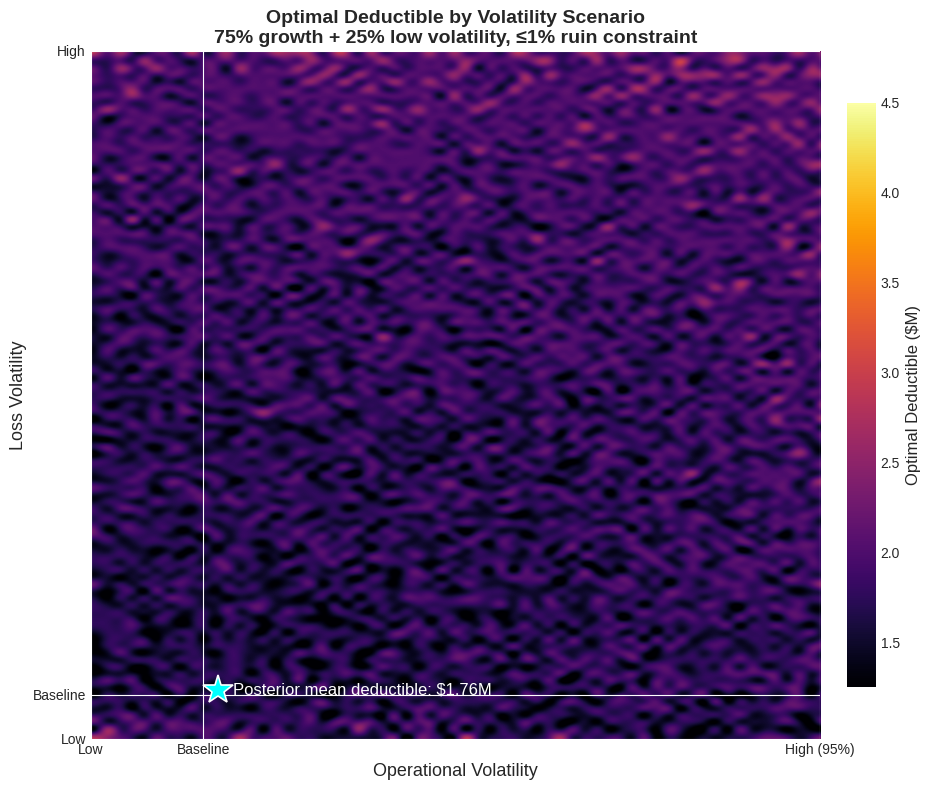


Posterior-weighted mean optimal deductible: $1.76M
  at loss vol = 1.099, op vol = 1.110


In [26]:
from matplotlib.colors import Normalize
import matplotlib.cm as mcm

opt_surface_M = optimal_surface / 1e6

# --- Posterior-weighted mean (single point) ---
loss_pdf = invgauss.pdf(loss_vol_scalar_samples,
                        mu=LOSS_SCALAR_MU, scale=LOSS_SCALAR_SCALE)
op_pdf   = invgauss.pdf(op_vol_scalar_samples,
                        mu=VOL_SCALAR_MU, scale=VOL_SCALAR_SCALE)
loss_w = loss_pdf / loss_pdf.sum()
op_w   = op_pdf / op_pdf.sum()

# Joint weight matrix and posterior-weighted expected optimal ded
joint_w = np.outer(loss_w, op_w)
posterior_mean_ded = np.sum(opt_surface_M * joint_w)

# Posterior-weighted position (expected scalar values)
posterior_loss_val = np.sum(loss_vol_scalar_samples * loss_w)
posterior_op_val   = np.sum(op_vol_scalar_samples * op_w)

# --- Calculate limits for plot and color scale ---
# Calculate 95th percentile for x-axis limit to hide extreme tail
op_limit_95 = np.percentile(op_vol_scalar_samples, 95)

# Calculate vmin/vmax based ONLY on the visible data subset
visible_mask = op_vol_scalar_samples <= op_limit_95
visible_data = opt_surface_M[:, visible_mask]
vmin, vmax = visible_data.min(), visible_data.max()

# --- Heatmap ---
fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(opt_surface_M, origin='lower', aspect='auto',
               cmap='inferno',
               extent=[op_vol_scalar_samples[0], op_vol_scalar_samples[-1],
                       loss_vol_scalar_samples[0], loss_vol_scalar_samples[-1]],
               interpolation='lanczos',
               vmin=vmin, vmax=vmax)  # <--- Use calculated limits here

ax.set_xlim(op_vol_scalar_samples[0], op_limit_95)

# Posterior-weighted mean marker
ax.plot(posterior_op_val, posterior_loss_val, marker='*',
        markersize=22, color='cyan', markeredgecolor='white',
        markeredgewidth=1.2, zorder=10,
        label=f'Posterior mean: ${posterior_mean_ded:.2f}M')
ax.text(posterior_op_val * 1.1, posterior_loss_val,
        f'Posterior mean deductible: ${posterior_mean_ded:.2f}M',
        ha='left', va='center', fontsize=12, color='white')

# --- Axis labels and ticks ---
ax.set_xlabel('Operational Volatility', fontsize=13)
ax.set_ylabel('Loss Volatility', fontsize=13)
ax.set_title('Optimal Deductible by Volatility Scenario\n'
             '75% growth + 25% low volatility, '
             '\u22641% ruin constraint',
             fontsize=14, fontweight='bold')

# X-axis ticks (Custom to handle 95% crop)
low_x = op_vol_scalar_samples[0]
mid_x = op_vol_scalar_samples[np.argmin(np.abs(op_vol_scalar_samples - 1.0))]
high_x = op_limit_95
ax.set_xticks([low_x, mid_x, high_x])
ax.set_xticklabels(['Low', 'Baseline', 'High (95%)'])

# Y-axis ticks (Standard)
low_y, high_y = loss_vol_scalar_samples[0], loss_vol_scalar_samples[-1]
mid_y = loss_vol_scalar_samples[np.argmin(np.abs(loss_vol_scalar_samples - 1.0))]
ax.set_yticks([low_y, mid_y, high_y])
ax.set_yticklabels(['Low', 'Baseline', 'High'])

cbar = fig.colorbar(im, ax=ax, shrink=0.85, pad=0.03)
cbar.set_label('Optimal Deductible ($M)', fontsize=12)

fig.patch.set_facecolor('white')
ax.set_facecolor('white')
plt.tight_layout()
plt.show()

print(f"\nPosterior-weighted mean optimal deductible: "
      f"${posterior_mean_ded:.2f}M")
print(f"  at loss vol = {posterior_loss_val:.3f}, "
      f"op vol = {posterior_op_val:.3f}")